In [1]:
import torch
import numpy as np

In [2]:
x = np.random.rand(2, 3)

In [3]:
x.sum(axis=1)

array([1.18678033, 1.62893071])

In [4]:
a = torch.tensor([[1., 2., 3.]])
b = torch.tensor([[4., 5., 6.]])

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
a = torch.rand(5, 10, requires_grad=True)
b = torch.rand(5, 10, requires_grad=True)
c = torch.rand(5, 10, requires_grad=True)
d = torch.sigmoid(a + b)
l = torch.trace(c @ d.t())

In [7]:
l.backward()

In [8]:
a.grad, b.grad

(tensor([[0.1739, 0.1682, 0.0513, 0.1276, 0.1502, 0.0710, 0.0540, 0.0773, 0.1672,
          0.0848],
         [0.1450, 0.0262, 0.0805, 0.1797, 0.0553, 0.0068, 0.1094, 0.1786, 0.1259,
          0.1279],
         [0.0995, 0.0051, 0.1225, 0.1498, 0.1696, 0.1418, 0.1251, 0.0857, 0.0325,
          0.1538],
         [0.0948, 0.1562, 0.1852, 0.0365, 0.0240, 0.0041, 0.1116, 0.1483, 0.1515,
          0.1391],
         [0.1312, 0.0153, 0.0424, 0.0482, 0.0612, 0.1519, 0.1138, 0.1706, 0.1524,
          0.0978]]),
 tensor([[0.1739, 0.1682, 0.0513, 0.1276, 0.1502, 0.0710, 0.0540, 0.0773, 0.1672,
          0.0848],
         [0.1450, 0.0262, 0.0805, 0.1797, 0.0553, 0.0068, 0.1094, 0.1786, 0.1259,
          0.1279],
         [0.0995, 0.0051, 0.1225, 0.1498, 0.1696, 0.1418, 0.1251, 0.0857, 0.0325,
          0.1538],
         [0.0948, 0.1562, 0.1852, 0.0365, 0.0240, 0.0041, 0.1116, 0.1483, 0.1515,
          0.1391],
         [0.1312, 0.0153, 0.0424, 0.0482, 0.0612, 0.1519, 0.1138, 0.1706, 0.1524,
       

In [9]:
c.grad

tensor([[0.6697, 0.6480, 0.7827, 0.6543, 0.7601, 0.7507, 0.7761, 0.7797, 0.7319,
         0.6693],
        [0.8137, 0.7373, 0.7148, 0.7507, 0.8300, 0.7549, 0.8212, 0.6160, 0.6525,
         0.5150],
        [0.7836, 0.8162, 0.6776, 0.6293, 0.6797, 0.7061, 0.7110, 0.6865, 0.6910,
         0.7593],
        [0.7603, 0.6384, 0.6798, 0.8356, 0.7433, 0.6404, 0.7349, 0.7885, 0.7272,
         0.7648],
        [0.7541, 0.5942, 0.7966, 0.6765, 0.7549, 0.7340, 0.8544, 0.7762, 0.6986,
         0.7235]])

In [10]:
c = torch.tanh(a)
l = torch.trace(c @ b.t())

In [11]:
l.backward()

In [12]:
a.grad = None
b.grad = None

In [13]:
with torch.no_grad():
    c = torch.tanh(a)
    l = torch.trace(c @ b.t())

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms as T

In [ ]:
train_set = MNIST('./MNIST', train=True, download=True, transform=T.ToTensor())
test_set = MNIST('./MNIST', train=False, transform=T.ToTensor())

In [17]:
len(train_set), len(test_set)

(60000, 10000)

In [18]:
train_set.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Class: 5


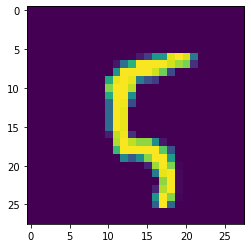

In [22]:
print('Class:', train_set[100][1])
plt.imshow(train_set[100][0].permute(1, 2, 0)[..., 0])
plt.show()

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, num_workers=4, pin_memory=True)

In [24]:
import torch
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
           nn.Linear(784, 256),
           nn.ReLU(),
           nn.Linear(256, 256),
           nn.ReLU(),
           nn.Linear(256, 10)
        )
        
    def forward(self, x):
        return self.linear(x)

In [25]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [26]:
set_random_seed(101)
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_accuracies = []


model.train()
for epoch in range(10):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        images = torch.flatten(images, start_dim=1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicts = outputs.argmax(dim=1)
        accuracy = (predicts == labels).to(torch.float).mean()
        train_losses += [loss.item()]
        train_accuracies += [accuracy.item()]


model.eval()
test_loss, test_accuracy = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images = torch.flatten(images, start_dim=1)
        outputs = model(images)
        loss = criterion(outputs, labels)

        predicts = outputs.argmax(dim=1)
        accuracy = (predicts == labels).to(torch.float).sum()
        test_loss += loss.item() * outputs.shape[0]
        test_accuracy += accuracy.item()

test_loss /= len(test_set)
test_accuracy /= len(test_set)

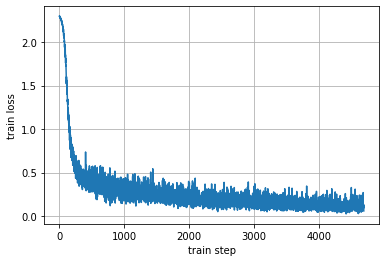

Test loss: 0.12090154956281185


In [30]:
plt.plot(range(len(train_losses)), train_losses)
plt.xlabel('train step')
plt.ylabel('train loss')
plt.grid()
plt.show()
print('Test loss:', test_loss)

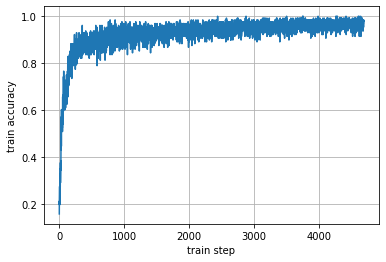

Test accuracy: 0.9638


In [33]:
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.xlabel('train step')
plt.ylabel('train accuracy')
plt.grid()
plt.show()
print('Test accuracy:', test_accuracy)